# Patrones de Puntos

El análisis de patrones de puntos se basa en la interpretación espacial de eventos localizados. Existen dos formas principales de entender estos puntos:

1. **Puntos como ubicaciones fijas:** En este enfoque, los puntos representan lugares donde se registra una medición y su posición es considerada exógena. El interés se centra en el valor medido, no en la ubicación. Por ejemplo, contar autos en una intersección fija.

2. **Puntos como expresiones de un proceso geográfico:** Aquí, tanto la ubicación como el valor medido son importantes. Los puntos reflejan un proceso continuo subyacente. Por ejemplo, medir alas de aves en distintos lugares permite inferir patrones ecológicos relacionados con su distribución y comportamiento.

Cuando los puntos representan eventos que pueden ocurrir en múltiples ubicaciones pero solo se observan en algunas, hablamos de un **patrón de puntos**. Este patrón puede ser:

- **No marcado:** Solo se conoce la ubicación del evento (por ejemplo, dónde se tomó una foto).
- **Marcado:** Se dispone de información adicional asociada al punto, como hora, tipo de dispositivo, o calidad de la imagen.

Estos patrones permiten estudiar la distribución espacial de los eventos y analizar su concentración, dispersión o relación con otros factores geográficos o contextuales.


## Introducción al Análisis de Patrones de Puntos

El análisis de patrones de puntos se enfoca en visualizar, describir, caracterizar estadísticamente y modelizar la distribución espacial de eventos puntuales. Su objetivo es comprender el proceso generador que da origen a los datos observados. Entre las preguntas centrales que busca responder este enfoque se encuentran:

- ¿Cómo se ve el patrón espacial?
- ¿Cómo se distribuyen los puntos en el espacio?
- ¿Existe alguna estructura en la forma en que se disponen las ubicaciones? ¿Hay concentración (agrupamiento) o dispersión?
- ¿Por qué los eventos ocurren en ciertos lugares y no en otros?

Es fundamental diferenciar entre **proceso** y **patrón**. El **proceso** hace referencia al mecanismo subyacente —no observable directamente— que genera los eventos. Por otro lado, el **patrón** es el resultado visible de dicho proceso. Aunque el patrón es lo que efectivamente observamos, el verdadero desafío analítico es **inferir el proceso** a partir de él.

En este capítulo, se introduce el análisis de patrones de puntos utilizando como ejemplo delitos contra personas, propiedad y seguridad pública en Quito-Ecuador en el periodo 2013-2016. Estas datos son tratados como eventos espaciales: en teoría podrían haberse dado en cualquier lugar, pero en la práctica se concentran en ciertas ubicaciones. Esta perspectiva permite estudiar cómo se agrupan o dispersan los puntos y revelar estructuras espaciales significativas.

Gracias a las herramientas del análisis espacial, es posible transformar una lista de coordenadas aparentemente caótica en una representación inteligible del comportamiento colectivo, permitiendo responder preguntas clave sobre centros de interés, dispersión y concentración de actividades en el espacio urbano.

## Nuevas Formas de Datos y su Aplicación al Estudio Urbano

El acceso a bases de datos georreferenciadas sobre delitos representa una valiosa oportunidad para analizar el comportamiento espacial de la criminalidad en las ciudades. Preguntas como: ¿dónde ocurren los delitos con mayor frecuencia?, ¿en qué momentos del año o del día son más comunes?, ¿por qué ciertos sectores concentran más incidentes que otros?, dejan de ser cuestiones abstractas cuando se dispone de registros espaciales detallados.

En este capítulo se analiza un conjunto de datos sobre delitos contra las personas, la propiedad y la seguridad pública ocurridos en **Quito, Ecuador, durante el periodo 2013–2016**. Estos datos permiten estudiar los patrones espaciales de la delincuencia y comprender cómo varía su distribución a lo largo del territorio urbano.

A partir de este ejemplo, se presentan herramientas y enfoques que permiten explorar y describir la distribución espacial de eventos delictivos, facilitando la identificación de zonas críticas, la evaluación de dispersiones o agrupamientos, y la formulación de hipótesis sobre los procesos sociales y urbanos que subyacen a estos patrones.




In [1]:
# Se define la URL desde la cual se descargará el archivo CSV que contiene los datos de delitos
uu = "https://raw.githubusercontent.com/vmoprojs/DataLectures/refs/heads/master/SpatialData/REQ_BASE_2013_2016.csv"

# Se importa la biblioteca pandas, útil para manipulación y análisis de datos estructurados
import pandas as pd

# Se lee el archivo CSV desde la URL indicada, especificando que el separador es punto y coma
# El argumento 'low_memory=False' evita advertencias relacionadas con tipos de datos mezclados
datos = pd.read_csv(uu, sep=";", low_memory=False)

# Se muestra un conteo de los valores únicos que tiene la columna 'TIPO_DELITO'
# Esto ayuda a conocer la frecuencia de cada tipo de delito registrado en los datos
datos.TIPO_DELITO.value_counts()

# Se crea una lista con los tres tipos de delitos que se desean filtrar
tipos = ["CONTRA LA PROPIEDAD", "CONTRA LAS PERSONAS", "CONTRA LA SEGURIDAD PUBLICA"]

# Se filtra el DataFrame para conservar solo las filas cuyo tipo de delito esté dentro de la lista 'tipos'
datos_clean = datos[datos["TIPO_DELITO"].isin(tipos)]

# Se vuelve a mostrar el conteo de delitos, pero ahora solo con los tipos seleccionados
datos_clean.TIPO_DELITO.value_counts()

# Se filtran los datos para conservar solo aquellos registros cuyo código de cantón es "1701"
# Este código corresponde al cantón Quito
datos_clean = datos_clean[datos_clean["cod_canton"] == "1701"]

# Se renombran las columnas 'EJE_X' y 'EJE_Y' a 'longitude' y 'latitude' respectivamente
# Esto facilita el trabajo posterior con coordenadas geográficas
datos_clean = datos_clean.rename(columns={
    'EJE_X': 'longitude',
    'EJE_Y': 'latitude'
})

# Se define una caja de recorte (bounding box) aproximada que delimita el área geográfica de Quito
# La bounding box contiene las coordenadas mínimas y máximas de longitud y latitud
bbox_quito = (-78.6, -0.4, -78.3, 0.05)

# Se filtran los datos para conservar solo aquellos registros cuyas coordenadas estén dentro de la bounding box de Quito
datos_clean = datos_clean[
    (datos_clean['longitude'] >= bbox_quito[0]) & 
    (datos_clean['longitude'] <= bbox_quito[2]) & 
    (datos_clean['latitude'] >= bbox_quito[1]) & 
    (datos_clean['latitude'] <= bbox_quito[3]) 
]


In [2]:
import numpy as np
import geopandas as gpd
import libpysal  as lps # pysal se dividio en submodulos especializados (libpysal, esda, mapclassify)
import seaborn as sns
import contextily as ctx
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN 
from shapely.geometry import Point
from pointpats import centrography

In [3]:
#
db = datos_clean
del datos, datos_clean

La tabla utilizada contiene información detallada sobre una muestra de 10878 registros de delitos. Cada fila corresponde a un delito individual y presenta las siguientes variables:

- **TIPO_DELITO**: Identificador de delito 'CONTRA LAS PERSONAS', 'CONTRA LA PROPIEDAD', 'CONTRA LA SEGURIDAD PUBLICA'.
- **SUBTIPO_DE_DELITO**: Categoría más específica del delito.
- **FECHA_DETENCION**: Fecha y hora exacta en la que fue la detención.
- **Coordenadas proyectadas (x,y)**: Versión transformada de la ubicación en el sistema de referencia Pseudo-Mercator, útil para análisis espaciales precisos.
- **Coordenadas (longitude,latitude)**: Versión transformada de la ubicación en el sistema de referencia Pseudo-Mercator, útil para análisis espaciales precisos.

Esta estructura de datos permite analizar tanto el comportamiento espacial como temporal de la actividad registrada, facilitando la identificación de patrones en el uso del espacio urbano.


In [4]:
# Se muestra información general del DataFrame 'db', como el número de filas, columnas, tipos de datos y uso de memoria.
db.info()

# 1. Crear geometría en EPSG:4326
# Se crea un nuevo GeoDataFrame 'gdf' a partir de una copia del DataFrame original 'db'
# La columna 'geometry' se genera combinando las columnas de longitud y latitud como objetos Point
# Se asigna el sistema de referencia de coordenadas (CRS) EPSG:4326, que corresponde a coordenadas geográficas (lat/lon en WGS84)
gdf = gpd.GeoDataFrame(
    db.copy(),
    geometry=[Point(xy) for xy in zip(db['longitude'], db['latitude'])],
    crs="EPSG:4326"
)

# 2. Transformar a EPSG:3857
# Se transforma el GeoDataFrame al sistema de coordenadas proyectadas EPSG:3857 (Web Mercator)
# Este sistema es útil para cálculos de distancias y visualización en mapas base como OpenStreetMap o CartoDB
gdf_3857 = gdf.to_crs(epsg=3857)

# 3. Extraer coordenadas transformadas y agregarlas al DataFrame original
# Se crean dos nuevas columnas en el DataFrame original 'db':
# - 'x': corresponde a la coordenada este (este-oeste) en metros del sistema EPSG:3857
# - 'y': corresponde a la coordenada norte (norte-sur) en metros del sistema EPSG:3857
db['x'] = gdf_3857.geometry.x
db['y'] = gdf_3857.geometry.y


<class 'pandas.core.frame.DataFrame'>
Index: 10878 entries, 75 to 73244
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TIPO_DELITO              10878 non-null  object 
 1   SUBTIPO_DE_DELITO        10878 non-null  object 
 2   FECHA_DETENCION          10878 non-null  object 
 3   NUMERO_DE_DETENCIONES    9783 non-null   float64
 4   ZONA                     10878 non-null  object 
 5   PROVINCIA                10878 non-null  object 
 6   cod_provincia            10878 non-null  object 
 7   CANTON                   10878 non-null  object 
 8   cod_canton               10878 non-null  object 
 9   PARROQUIA                10878 non-null  object 
 10  cod_parroquia            10878 non-null  object 
 11  DISTRITO                 10878 non-null  object 
 12  cod_distrito             10878 non-null  object 
 13  CIRCUITO                 10878 non-null  object 
 14  cod_circuito             1

### Visualización de Patrones de Puntos

Existen múltiples formas de visualizar patrones espaciales de puntos, y la elección del método depende del mensaje que se desea comunicar.

#### Representación básica con puntos en un mapa

El primer paso para explorar la dimensión espacial de un conjunto de datos es representarlo gráficamente. Una forma sencilla de hacerlo es mediante un **diagrama de dispersión (scatterplot)**, que permite observar cómo se distribuyen los eventos en el espacio.

Este tipo de visualización consiste en graficar las coordenadas geográficas (por ejemplo, latitud y longitud) como puntos individuales sobre un mapa o plano de referencia. A pesar de su simplicidad, esta técnica es útil para identificar concentraciones, vacíos, o patrones iniciales de agrupamiento.

En la siguiente Figura, se muestra un ejemplo de este tipo de visualización utilizando la biblioteca `seaborn`, una herramienta común en el análisis de datos geoespaciales con Python.


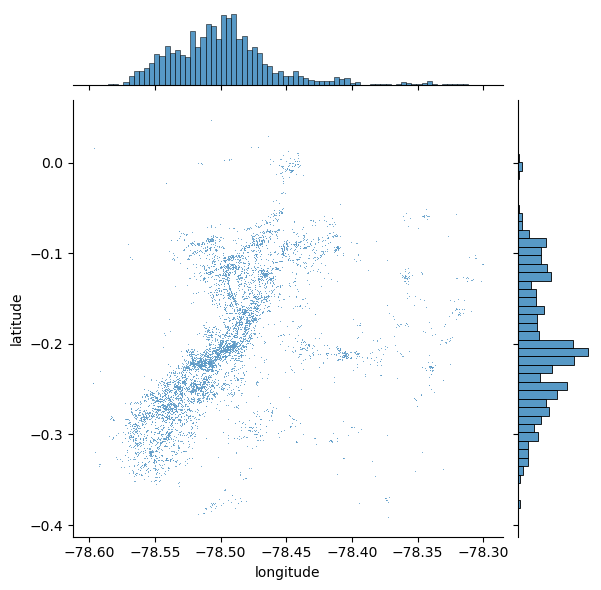

In [5]:
sns.jointplot(x="longitude", y="latitude", data=db, s=0.5);

### Añadiendo Contexto a la Visualización

El diagrama de dispersión inicial ofrece un buen punto de partida: permite observar que los puntos tienden a concentrarse hacia el centro del área cubierta, siguiendo un patrón no aleatorio. Además, dentro de ese patrón general, se pueden distinguir agrupamientos más localizados.

No obstante, esta visualización presenta dos limitaciones importantes:

1. **Falta de contexto geográfico**: no hay referencia visual del entorno urbano en el que ocurren los eventos.
2. **Alta densidad de puntos**: en zonas con mucha concentración, los puntos se superponen tanto que resulta difícil distinguir detalles o interpretar patrones con claridad.

#### Incorporando un mapa base

Para superar estas limitaciones, el primer paso es proporcionar **contexto geográfico**. Una manera sencilla y eficaz de hacerlo es **superponer un mapa base** (tile map) proveniente de servicios en línea. Esto permite visualizar los puntos dentro del entorno urbano real, facilitando la interpretación espacial.

En este caso, se utiliza la biblioteca `contextily` (alias `ctx`), que permite integrar mapas base fácilmente en gráficos de datos geográficos. Combinándola con `jointplot`, se genera la siguiente Figura, en la que los puntos se ubican sobre un fondo de mapa urbano, mejorando significativamente la legibilidad y comprensión de los patrones espaciales.


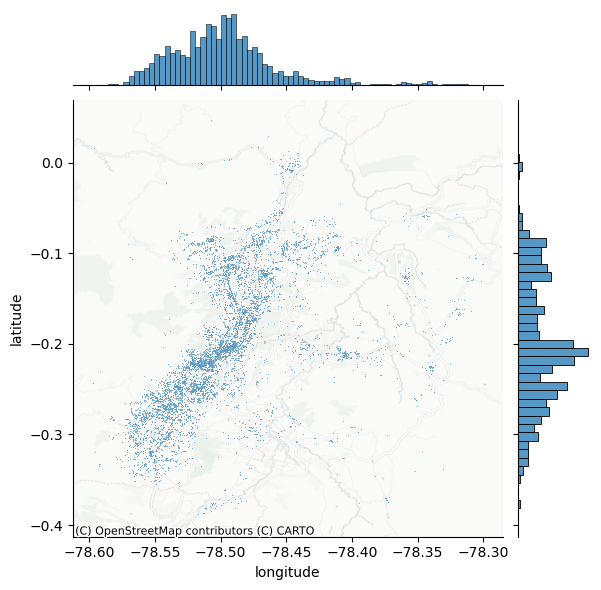

In [6]:

# Generate scatter plot
joint_axes = sns.jointplot(
    x="longitude", y="latitude", data=db, s=0.5
)
ctx.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=ctx.providers.CartoDB.PositronNoLabels,
);


Una mejora clave en la visualización consiste en **extraer el eje donde se grafican los puntos** y superponer allí un **mapa base**. Para ello, es importante especificar correctamente el sistema de referencia de coordenadas (CRS), en este caso **WGS84**, ya que se están utilizando coordenadas de latitud y longitud.

### Ventajas de incluir un mapa base

Comparado con el gráfico anterior, la adición de un fondo cartográfico mejora notablemente la interpretación espacial del patrón. En el caso original con datos de **delitos**, el uso del mapa permite:

- Entender mejor la relación entre la distribución de puntos y el entorno urbano.
- Visualizar con mayor precisión las zonas de alta concentración.
- Identificar calles, plazas o barrios específicos que coinciden con los agrupamientos observados.

Este principio se puede aplicar igualmente a otros tipos de datos espaciales, como la localización de delitos en una ciudad, permitiendo analizar cómo se relacionan los eventos con el espacio construido y los elementos del entorno.


## Representar la Densidad con Hexbinning

Un desafío común al visualizar grandes volúmenes de puntos geográficos es el **exceso de superposición**. Cuando muchos eventos se concentran en una misma área, como sucede con los delitos en ciertos sectores de la ciudad, el uso de puntos opacos uno sobre otro dificulta discernir patrones. Por ejemplo, en la siguiente Figura (al centro-izquierda del mapa), se observa una aparente gran concentración de delitos, pero no es posible determinar visualmente si toda esa zona tiene la misma intensidad o si existen focos específicos con mayor actividad.

### Solución: de puntos individuales a superficies

Una manera de abordar este problema consiste en transformar la visualización de puntos en una **superficie de densidad**, lo que equivale a construir un **histograma espacial bidimensional**. El procedimiento consiste en:

- Dividir el espacio en una cuadrícula regular (de celdas cuadradas o hexagonales).
- Contar cuántos eventos caen dentro de cada celda.
- Representar los conteos mediante colores, al estilo de un mapa coroplético.

Este enfoque es intuitivo, fácil de interpretar y elimina algunas distorsiones asociadas a otros métodos, especialmente cuando se usa una malla **hexagonal** (hexbin), la cual ofrece ventajas como una conectividad más uniforme entre celdas y menor distorsión visual que las cuadrículas cuadradas.

La creación de este tipo de visualización es sencilla en Python utilizando la función `hexbin`, y permite identificar rápidamente zonas de alta y baja concentración de eventos dentro del área de estudio.


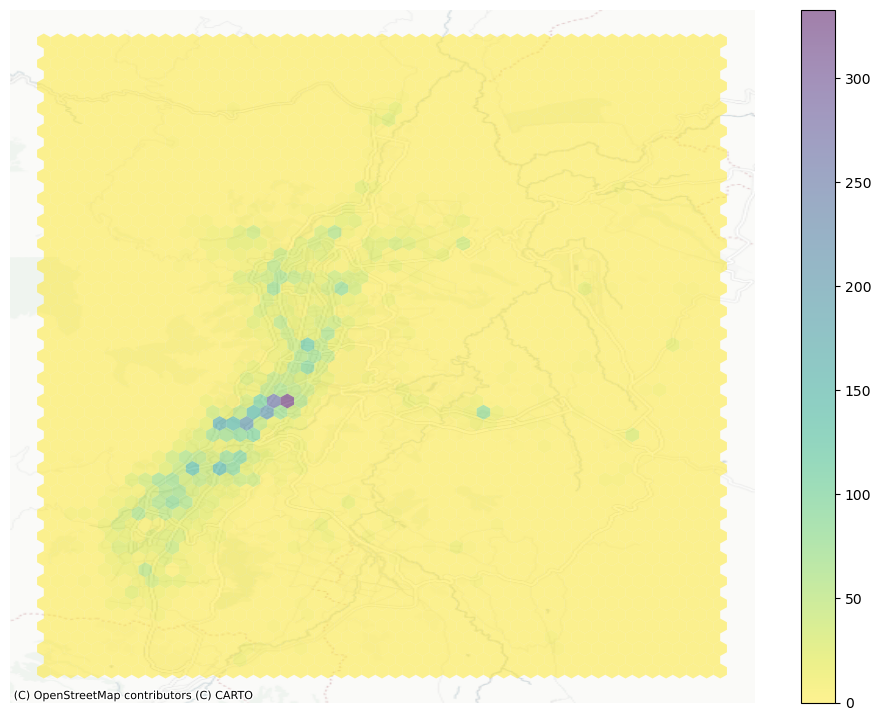

In [7]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    db["x"],
    db["y"],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r",
)
# Add basemap
ctx.add_basemap(
    ax, 
    #crs="EPSG:4326",
    source=ctx.providers.CartoDB.PositronNoLabels
)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

## Otro Tipo de Densidad: Estimación de Densidad por Kernel (KDE)

El uso de cuadrículas regulares, como vimos con el **hexbinning**, es el equivalente espacial de un histograma: el usuario define el número de “celdas” o “recipientes” y se contabilizan cuántos eventos caen dentro de cada uno. Este método es rápido, eficiente y puede ofrecer mucho detalle si se usan suficientes divisiones. Sin embargo, implica una **discretización** de un fenómeno que, en esencia, es **continuo**, lo cual puede introducir distorsiones —como las derivadas del problema de la unidad espacial modificable (MAUP).

El MAUP ocurre porque los resultados de un análisis espacial (como una correlación, una regresión o un mapa de calor) pueden variar significativamente según cómo se definan las unidades espaciales (por ejemplo, comunas, distritos, cuadrantes, manzanas, etc.).

El MAUP tiene dos componentes principales:

**Efecto de escala**: Los resultados cambian si se usan unidades más grandes o más pequeñas (por ejemplo, provincias vs. comunas).
- Un análisis a nivel de región puede mostrar una correlación diferente a uno hecho a nivel de barrio.

**Efecto de zonificación**: Aun si se mantiene el mismo número de unidades, los resultados pueden cambiar según cómo se agrupen espacialmente.
- Por ejemplo, si se redistribuyen los límites de las comunas manteniendo la cantidad de unidades, las estadísticas agregadas también pueden variar.

Introducir sesgos o interpretaciones erróneas si se concluye que existe una relación estadística cuando en realidad depende de cómo se agruparon los datos espacialmente.

### Alternativa: Estimación de Densidad por Kernel (KDE)

Una alternativa más flexible es la **estimación de densidad por kernel (KDE)**, que permite aproximar empíricamente una función de densidad de probabilidad. En lugar de usar celdas rígidas, la KDE coloca una malla de puntos sobre el espacio de análisis y aplica una **función kernel** sobre cada uno. Esta función asigna pesos a los eventos cercanos según la distancia: los eventos más cercanos contribuyen más, y los lejanos, menos.

El resultado final es una **superficie continua** que representa la densidad estimada de eventos en cada punto del espacio.

- La función kernel más común es la **gaussiana**, que aplica una distribución normal como peso.
- Esta superficie puede interpretarse como una **probabilidad suavizada de ocurrencia** de eventos, evaluable en cualquier lugar del área de estudio.


Dado un conjunto de datos $ x_1, x_2, \dots, x_n $, la función de densidad estimada en un punto $ x $ es:

$$
\hat{f}(x) = \frac{1}{n h} \sum_{i=1}^{n} K\left( \frac{x - x_i}{h} \right)
$$

### Donde:
- $ n $: número de observaciones.
- $ h $: **bandwidth** o ancho de banda (controla la suavidad).
- $ K(u) $: función núcleo (kernel), comúnmente una Gaussiana:
  $$
  K(u) = \frac{1}{\sqrt{2\pi}} e^{-u^2/2}
  $$
- $ x_i $: valores observados.
- $ x $: punto donde se evalúa la densidad.


¿Cómo se forma la curva?

1. A cada valor $ x_i $, se le asigna una campana (kernel).
2. Se suman todas esas campanas.
3. El resultado se normaliza (área bajo la curva = 1).

> Es como dibujar una campana en cada dato y observar cómo se superponen.

¿Qué hace `sns.kdeplot` internamente?

- Usa un **kernel Gaussiano** por defecto.
- Estima automáticamente el **bandwidth**.
- Puede hacer estimación univariada (1D) o bivariada (2D).

Comparación con Histograma

| Característica          | Histograma                  | KDE (`kdeplot`)                         |
|-------------------------|-----------------------------|------------------------------------------|
| Forma                   | Escalones                   | Curva suave                              |
| Parámetros              | Número de bins              | Bandwidth (`bw_adjust`)                  |
| Suavidad                | Baja                        | Alta (dependiendo del `h`)               |
| Asume forma paramétrica| No                          | No (no paramétrica)     


A continuación se presentan los kernels más utilizados en estimación de densidad:

| Nombre del Kernel        | Fórmula Matemática                                             | Soporte          | Características clave                          |
|--------------------------|----------------------------------------------------------------|------------------|-----------------------------------------------|
| **Gaussiano**            | $ K(u) = \frac{1}{\sqrt{2\pi}} e^{-u^2/2} $                  | $ (-\infty, \infty) $ | Muy suave, simétrico, el más usado.         |
| **Uniforme (cuadrado)**  | $ K(u) = \frac{1}{2} \cdot \mathbb{1}_{|u| \leq 1} $           | $ [-1, 1] $     | Corte brusco, poco suave.                    |
| **Triangular**           | $ K(u) = (1 - |u|) \cdot \mathbb{1}_{|u| \leq 1} $            | $ [-1, 1] $     | Forma lineal, más suave que el uniforme.     |
| **Epanechnikov**         | $ K(u) = \frac{3}{4}(1 - u^2) \cdot \mathbb{1}_{|u| \leq 1} $  | $ [-1, 1] $     | Óptimo en teoría de error cuadrático medio.  |
| **Biweight (cuadrático)**| $ K(u) = \frac{15}{16}(1 - u^2)^2 \cdot \mathbb{1}_{|u| \leq 1} $ | $ [-1, 1] $  | Más suave, decae más rápido en los bordes.   |
| **Triweight**            | $ K(u) = \frac{35}{32}(1 - u^2)^3 \cdot \mathbb{1}_{|u| \leq 1} $ | $ [-1, 1] $  | Muy suave, con bordes planos.                |
| **Coseno**               | $ K(u) = \frac{\pi}{4} \cos\left( \frac{\pi u}{2} \right) \cdot \mathbb{1}_{|u| \leq 1} $ | $ [-1, 1] $ | Suave, forma de onda.                        |

> $ \mathbb{1}_{|u| \leq 1} $: función indicadora que vale 1 si $|u| \leq 1 $, y 0 en caso contrario.


En Python, crear un mapa de densidad con kernel gaussiano es bastante sencillo utilizando la función `seaborn.kdeplot()`, como se muestra en la siguiente Figura. Esta técnica es especialmente útil para identificar **zonas calientes** (hotspots) y visualizar la concentración de fenómenos de forma continua y precisa.


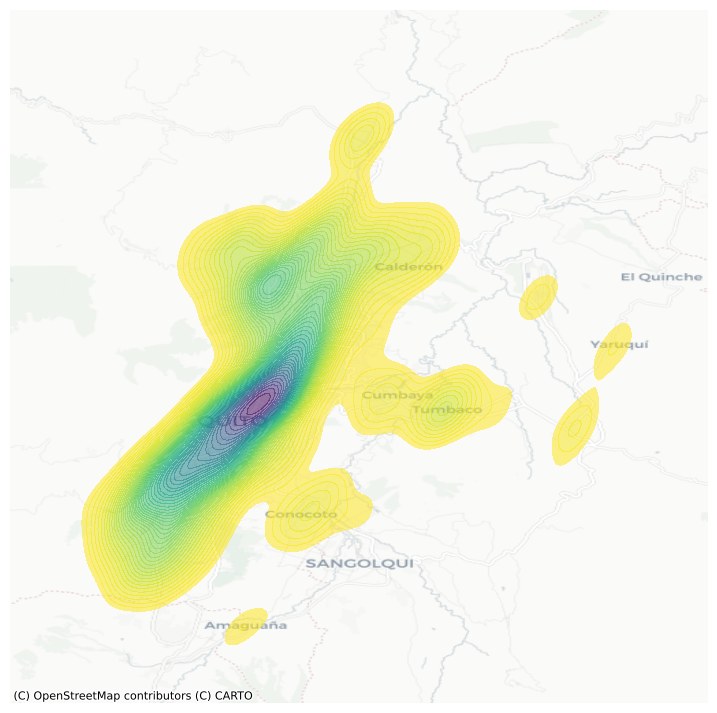

In [10]:
# Se crea una figura y un eje (ax) para graficar. La figura tendrá un solo subplot de tamaño 9x9 pulgadas.
f, ax = plt.subplots(1, figsize=(9, 9))

# Se genera y añade un gráfico de densidad por núcleo (KDE) a partir de las coordenadas proyectadas (x, y)
# Este gráfico muestra las zonas de mayor concentración de puntos (delitos, por ejemplo)
# Parámetros clave:
# - n_levels=50: se crean 50 niveles de contorno, proporcionando un sombreado fino
# - fill=True: rellena las áreas entre los contornos
# - alpha=0.55: transparencia del 55%, permite ver el mapa base por debajo
# - cmap="viridis_r": usa el colormap viridis invertido (de amarillo a púrpura)
sns.kdeplot(
    x="x",
    y="y",
    data=db,
    n_levels=50,
    fill=True,
    alpha=0.55,
    cmap="viridis_r",
)

# Se añade un mapa base al gráfico utilizando contextily (ctx)
# El mapa base proviene del proveedor CartoDB con el estilo "Positron" (fondo claro y minimalista)
# El mapa base se ajusta automáticamente a las coordenadas del eje (que están en EPSG:3857)
ctx.add_basemap(
    ax,
    #crs="EPSG:4326",  # Comentado porque la proyección ya está en 3857
    source=ctx.providers.CartoDB.Positron
)

# Se eliminan los ejes del gráfico (tanto las marcas como los números), para una visualización más limpia
ax.set_axis_off()



El resultado de aplicar una estimación de densidad por kernel (**KDE**) es una superficie **más suave y continua**, que conserva la estructura general observada en el hexbin, pero con **transiciones más graduales** entre áreas de distinta intensidad. Esta suavidad permite una **mejor generalización** de la distribución teórica de los eventos en el espacio.

### Interpretación técnica y utilidad

Desde el punto de vista técnico, la naturaleza continua de la función KDE implica que la **probabilidad exacta de un evento en un punto específico es cero**, ya que se trata de una función de densidad, no de una probabilidad puntual. Sin embargo, al considerar un área alrededor de ese punto, sí se puede calcular la **probabilidad de que un evento ocurra dentro de esa región**.

Esto hace que la KDE sea especialmente útil en dos sentidos:

- Permite **escapar de las limitaciones impuestas por las cuadrículas regulares** (cuadradas o hexagonales).
- Ofrece una representación **más realista de fenómenos espaciales continuos**, como la concentración de delitos, la movilidad urbana o la propagación de enfermedades.

La KDE entrega una visualización más fluida y analíticamente potente para fenómenos que no se distribuyen de forma estrictamente discreta, facilitando la identificación de patrones espaciales relevantes.


## Centrografía: Medidas de Centralidad Espacial

La **centrografía** es el estudio de la **centralidad** en un patrón de puntos. Este concepto se refiere tanto a la **ubicación general** como a la **dispersión** del conjunto de eventos en el espacio. Así como el hexbin puede interpretarse como un “histograma espacial”, la centrografía cumple una función similar a las medidas de **tendencia central** (como la media o la mediana) en estadística tradicional.

### ¿Para qué sirve la centrografía?

Las medidas centrográficas permiten **resumir distribuciones espaciales** de manera compacta, por ejemplo, mediante un único punto que representa el “centro” de la concentración de eventos.

Estas medidas son útiles para:

- Determinar **dónde** se localiza el centro espacial de un fenómeno.
- Evaluar **cuán dispersos** están los eventos en torno a ese centro.
- Identificar si la **forma del patrón** es regular, alargada o irregular.

### Aplicaciones

En el contexto del análisis urbano, como el estudio de delitos en una ciudad, la centrografía permite:

- Detectar **cambios en la localización de hotspots** delictivos a lo largo del tiempo.
- Comparar la concentración espacial de distintos tipos de delitos.
- Estudiar la evolución del **desplazamiento del centro de gravedad** del crimen en relación con variables urbanas, sociales o económicas.

La centrografía ofrece herramientas cuantitativas para describir y comparar la estructura espacial de fenómenos distribuidos en forma de puntos.


### Tendencia Central: Medidas de Ubicación en un Patrón de Puntos

Una de las medidas más comunes de tendencia central en un patrón de puntos es el **centro de masa**. Este punto representa el centro geométrico del patrón, y su cálculo depende de si el patrón está **marcado** (con atributos adicionales) o **no marcado**.

**Centro de masa y media espacial**

- En **patrones no marcados**, el centro de masa equivale al **centro medio**, es decir, el promedio de las coordenadas de todos los puntos. Es una medida sencilla que resume la ubicación general del fenómeno.
- En **patrones marcados**, el centro de masa toma en cuenta los valores de la marca (por ejemplo, intensidad, severidad, frecuencia), lo que desplaza el centro hacia las observaciones con valores más altos.

**Centro mediano**

Otra medida relevante es el **centro mediano**, que es análogo a la mediana tradicional. Se define como el punto que divide el conjunto de eventos de manera que:

- La mitad se ubica **a la derecha** y la otra mitad **a la izquierda**, y
- La mitad se ubica **por encima** y la otra **por debajo**.

Este tipo de centro es más **robusto ante valores extremos** o distribuciones irregulares.

**Aplicación práctica**

En Python, se puede analizar el **centro medio** de un patrón de puntos utilizando el paquete `pointpats`, que facilita el cálculo de diversas medidas centrográficas.

La librería `pointpats` (Point Pattern Analysis Tools) forma parte del ecosistema `PySAL` y está diseñada para realizar análisis estadístico de patrones de puntos espaciales. Permite explorar la distribución espacial de eventos y evaluar si los puntos se distribuyen de manera aleatoria, agrupada o dispersa. Las principales funcionalidades son:

**1. Funciones de análisis de distancia**

Estas funciones permiten evaluar la distancia entre puntos o hacia el vacío espacial y se utilizan comúnmente para detectar patrones de agrupamiento o dispersión.

| Función | Descripción |
|--------|-------------|
| `G(pp)` | Calcula la función G, que evalúa la distribución de distancias desde cada punto al vecino más cercano. Detecta agrupamiento a pequeña escala. |
| `F(pp)` | Calcula la función F, que mide la distancia desde puntos generados aleatoriamente en el espacio hacia el punto más cercano del patrón. Útil para detectar vacíos o dispersión. |
| `K(pp)` | Calcula la función K de Ripley, que estima el número esperado de puntos dentro de una distancia \( r \) desde cualquier punto. Detecta agrupamiento a múltiples escalas. |
| `L(pp)` | Transformación de la función K que facilita su interpretación lineal bajo una hipótesis de aleatoriedad completa (CSR). |

**2. Estadísticas espaciales y pruebas**

Estas funciones evalúan la uniformidad del patrón de puntos mediante pruebas estadísticas.

| Función | Descripción |
|--------|-------------|
| `quadrat_counts(pp, nx, ny)` | Divide el área de estudio en una cuadrícula (nx por ny) y cuenta la cantidad de puntos en cada celda. |
| `quadrat_test(pp, nx, ny)` | Aplica una prueba chi-cuadrado sobre los conteos por cuadrante para evaluar si el patrón difiere de una distribución uniforme. |
| `mean_nnd(pp)` | Calcula la distancia promedio al vecino más cercano del patrón y la compara con la esperada bajo CSR. |

**3. Generación de patrones y simulaciones**

Estas funciones permiten simular patrones de puntos aleatorios bajo el supuesto de aleatoriedad completa (CSR), útiles como referencia para contrastes estadísticos.

| Función | Descripción |
|--------|-------------|
| `PoissonPointProcess(window, npoints, asPP=True)` | Genera un patrón de puntos aleatorio dentro de una ventana rectangular definida. |
| `PointPattern(points)` | Clase que representa un conjunto de puntos y ofrece métodos para calcular estadísticas espaciales (como distancias, centroides, varianza, etc.). |
| `as_window(array)` | Define la ventana espacial del análisis a partir de coordenadas límite o bounding box. |


Estas métricas permiten entender no solo **dónde** se concentran los eventos (como delitos, por ejemplo), sino también cómo se **desplaza o cambia el centro** del fenómeno a lo largo del tiempo o entre distintas categorías.


In [12]:
mean_center = centrography.mean_center(db[["x", "y"]])
med_center = centrography.euclidean_median(db[["x", "y"]])

La forma más clara de interpretar el **centro medio** de un patrón de puntos es **visualizarlo en conjunto con los propios eventos**, superponiéndolos en un mismo gráfico. Esta representación permite observar de forma intuitiva cómo se relaciona la ubicación promedio con la distribución general del fenómeno.

**Ejemplo gráfico**

En la siguienten Figura se ilustra esta idea mostrando:

- El **patrón de puntos** completo (por ejemplo, ubicaciones de delitos).
- El **centro medio**, marcado como un punto distinto (generalmente en color y forma contrastantes).

Esta comparación gráfica facilita:

- Evaluar si el centro refleja bien la distribución del conjunto.
- Detectar si existen **asimetrías** o **agrupamientos** que alejan el centro de lo que visualmente parecería más representativo.
- Comparar centros medios de distintos períodos o categorías de eventos.

Este tipo de análisis visual es particularmente útil en contextos urbanos, como el estudio de delitos en Quito, donde el desplazamiento del centro puede estar asociado a dinámicas socioespaciales relevantes.


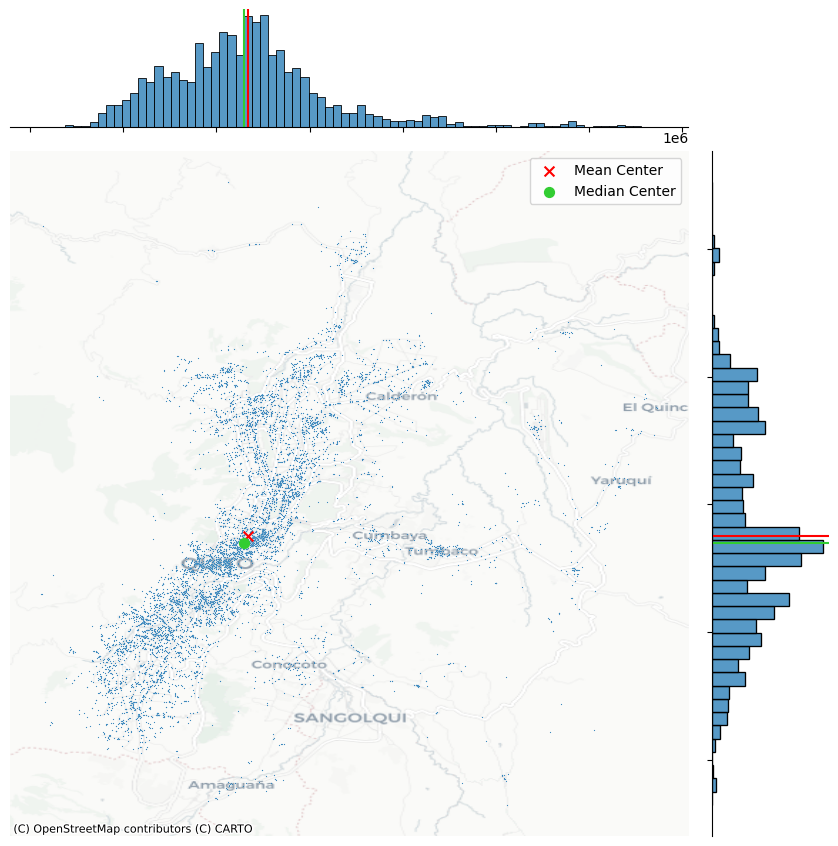

In [16]:
# Se genera un gráfico de dispersión bivariado (x vs. y) con gráficos marginales
# 's=0.75' indica el tamaño de los puntos, y 'height=9' define el tamaño de la figura en pulgadas
joint_axes = sns.jointplot(
    x="x", y="y", data=db, s=0.75, height=9
)

# Se añade el centroide (media de las coordenadas) al gráfico principal como un punto rojo con forma de 'x'
# 'mean_center' debe ser una tupla/lista con (x_mean, y_mean)
joint_axes.ax_joint.scatter(
    *mean_center, color="red", marker="x", s=50, label="Mean Center"
)

# Se añaden líneas marginales en rojo en los histogramas superior e izquierdo, indicando las coordenadas de la media
joint_axes.ax_marg_x.axvline(mean_center[0], color="red")
joint_axes.ax_marg_y.axhline(mean_center[1], color="red")

# Se añade el centro mediano (mediana de las coordenadas) como un punto verde con forma de círculo
# 'med_center' también debe ser una tupla/lista con (x_median, y_median)
joint_axes.ax_joint.scatter(
    *med_center,
    color="limegreen",
    marker="o",
    s=50,
    label="Median Center"
)

# Se añaden líneas marginales en color verde, indicando las coordenadas de la mediana
joint_axes.ax_marg_x.axvline(med_center[0], color="limegreen")
joint_axes.ax_marg_y.axhline(med_center[1], color="limegreen")

# Se agrega una leyenda al gráfico conjunto, que mostrará las etiquetas para los centros medio y mediano
joint_axes.ax_joint.legend()

# Se añade un mapa base (CartoDB Positron) detrás del gráfico de dispersión principal
# El CRS debe coincidir con EPSG:3857, ya que se trabaja con coordenadas proyectadas
ctx.add_basemap(
    joint_axes.ax_joint,
    # crs="EPSG:4326",  # Comentado ya que se asume que los datos están en EPSG:3857
    source=ctx.providers.CartoDB.Positron
)

# Se ocultan los ejes del gráfico principal para una visualización más limpia
joint_axes.ax_joint.set_axis_off()

# Se muestra el gráfico final
plt.show()


Este gráfico presenta un análisis exploratorio espacial de puntos de delitos georreferenciados en la ciudad de Quito, Ecuador.

Mapa Central: Distribución de Puntos

- Cada **punto azul** representa un evento delictivo registrado con coordenadas geográficas.
- Se observa una **alta concentración de delitos en el centro y suroeste de la ciudad**.
- Las zonas periféricas (Calderón, Cumbayá, Tumbaco, Yaruquí, Amaguaña) presentan menor densidad de eventos.
- El patrón indica **concentración espacial**: los delitos no están distribuidos aleatoriamente.

Centros de distribución

- 🔴 **Mean Center (Centroide medio)**:
  - Es el promedio de todas las coordenadas (latitud y longitud).
  - Sensible a valores extremos (outliers).
- 🟢 **Median Center (Centroide mediano)**:
  - Minimiza la suma de distancias absolutas a todos los puntos.
  - Es más robusto frente a valores atípicos.
- La cercanía entre ambos centros sugiere una distribución **moderadamente simétrica**, aunque con dispersión hacia el norte y este.

Histogramas Marginales

- **Histograma superior (eje X)**:
  - Muestra la distribución este-oeste de los delitos.
  - Concentración evidente en el rango medio del eje longitudinal.
- **Histograma derecho (eje Y)**:
  - Muestra la distribución norte-sur.
  - La mayor densidad se ubica en el eje central del área urbana.
- Líneas roja y verde marcan el centro **medio** y **mediano** sobre cada eje.


### Dispersión: Medida de Extensión Espacial

Una medida clásica de **dispersión espacial** en centrografía es la **distancia estándar**. Esta métrica cuantifica el **promedio de las distancias de todos los puntos respecto al centro del patrón**, típicamente el **centro de masa** (centro medio).

**¿Qué nos dice la distancia estándar?**

- Permite estimar **qué tan dispersos** están los eventos alrededor del centro.
- Cuanto mayor sea esta distancia, **más extendido** es el patrón de puntos en el espacio.
- Una distancia baja sugiere una **alta concentración** o agrupamiento en torno al centro.

**Cálculo en Python**

La distancia estándar se puede calcular fácilmente con el paquete `pointpats`, utilizando la función `std_distance()`, que automatiza el proceso:

1. Se calcula el centro medio del conjunto de puntos.
2. Se obtiene la distancia de cada punto a ese centro.
3. Se promedia dicha distancia para obtener la medida global de dispersión.

**Aplicación**

En contextos como el análisis delictivo en ciudades:

- Esta métrica ayuda a entender **la extensión geográfica del fenómeno**.
- Comparar la distancia estándar entre distintos años o tipos de delito permite observar **cambios en la distribución espacial**.
- También puede apoyar decisiones sobre **cobertura territorial** de intervenciones o vigilancia.

En resumen, la distancia estándar resume en un solo valor cuán amplio o concentrado es un patrón de eventos en el territorio.


In [17]:
centrography.std_distance(db[["x", "y"]])

np.float64(9160.760525257383)

En el caso de nuestro ejemplo, una distancia estándar de aproximadamente **9161 metros** indica que, en promedio, los delitos se dieron a esa distancia del **centro medio**. Este valor proporciona una idea general del **radio de dispersión** de los eventos en el espacio.

**Elipse de desviación estándar**

Una herramienta visual complementaria y muy útil en centrografía es la **elipse de desviación estándar** (o **elipse estándar**). Esta elipse se construye a partir de los datos espaciales y refleja:

- El **centro** del patrón.
- La **dispersión** en dos direcciones principales (ejes mayor y menor).
- La **orientación** espacial predominante del conjunto de puntos.

**¿Qué muestra esta elipse?**

- La **forma** de la elipse indica si el patrón es más **alargado** o **circular**.
- Su **inclinación** sugiere la dirección principal en la que se distribuyen los eventos.
- Su **tamaño** se relaciona con la magnitud de la dispersión en cada eje.

**Cálculo en Python**

Para crear esta elipse en Python, se puede usar la función `ellipse()` del paquete `pointpats`, que calcula automáticamente:

- La longitud de los ejes mayor y menor.
- El ángulo de rotación de la elipse respecto al eje horizontal.
- La ubicación del centro.

Esta visualización es especialmente valiosa en análisis urbanos (como el estudio de delitos), ya que permite observar **tendencias espaciales predominantes**, **zonas de elongación** del fenómeno y **posibles desplazamientos** en su orientación a lo largo del tiempo.


In [18]:
major, minor, rotation = centrography.ellipse(db[["x", "y"]])

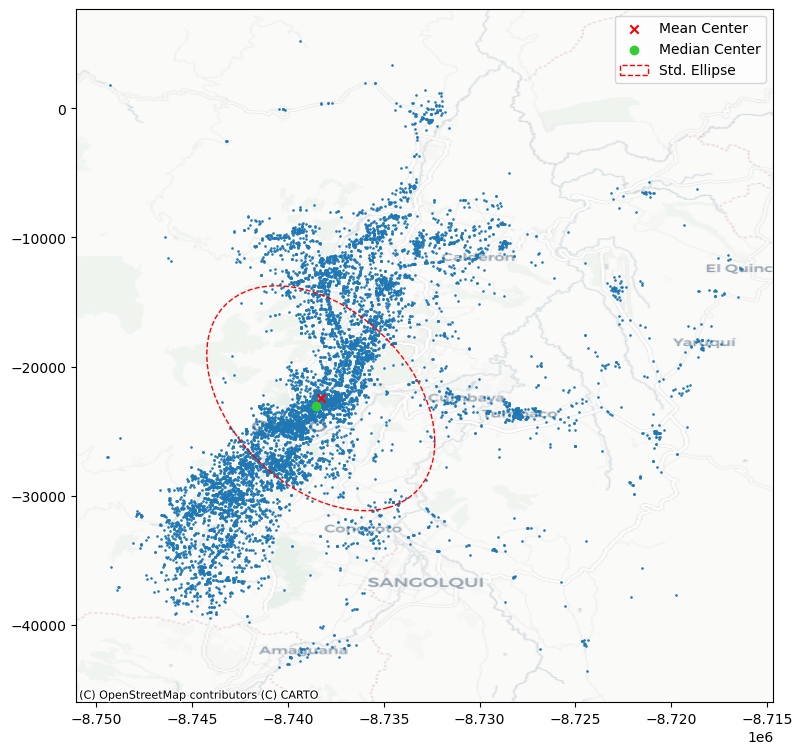

In [19]:
from matplotlib.patches import Ellipse  # Se importa la clase Ellipse para poder graficar una elipse en matplotlib

# Se crea una figura y un eje para la visualización, de tamaño 9x9 pulgadas
f, ax = plt.subplots(1, figsize=(9, 9))

# Se grafican los puntos del DataFrame (eventos geográficos proyectados en coordenadas x, y)
# Cada punto representa un evento (por ejemplo, delitos)
ax.scatter(db["x"], db["y"], s=0.75)

# Se añade el centroide (media de las coordenadas) con un marcador en forma de "x" roja
ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")

# Se añade el centro mediano (mediana de coordenadas) con un círculo verde
ax.scatter(*med_center, color="limegreen", marker="o", label="Median Center")

# Se construye la elipse estándar (elipse de dispersión) usando matplotlib.patches.Ellipse
ellipse = Ellipse(
    xy=mean_center,           # Centro de la elipse en el centroide
    width=major * 2,          # Longitud total del eje mayor (se multiplica por 2 porque la función solo da el semieje)
    height=minor * 2,         # Longitud total del eje menor
    angle=np.rad2deg(rotation),  # Se convierte el ángulo de rotación de radianes a grados
    facecolor="none",         # El interior de la elipse será transparente
    edgecolor="red",          # El borde de la elipse será rojo
    linestyle="--",           # Línea discontinua para diferenciarla visualmente
    label="Std. Ellipse"      # Etiqueta para la leyenda
)

# Se añade la elipse al gráfico
ax.add_patch(ellipse)

# Se muestra la leyenda con los elementos agregados (centros y elipse)
ax.legend()

# Se añade un mapa base (estilo Positron de CartoDB) al gráfico para dar contexto geográfico
# El mapa base debe coincidir con el CRS del sistema (se asume EPSG:3857)
ctx.add_basemap(
    ax, 
    # crs="EPSG:4326",  # Comentado porque los datos ya están en coordenadas proyectadas
    source=ctx.providers.CartoDB.Positron
)

# Finalmente, se muestra el gráfico
plt.show()


- Los delitos están altamente concentrados en una franja urbana que se extiende de norte a sur por el centro de Quito.
- La forma alargada del elipsoide indica que la dispersión espacial es mayor a lo largo del eje noreste-suroeste.
- La cercanía entre el centroide medio y el centroide mediano sugiere que no hay una asimetría extrema en la distribución.
- Las zonas periféricas, como el este y sureste del distrito, presentan menor densidad de delitos.

### Extensión: Medidas de Cobertura Espacial en Centrografía

La última categoría de medidas centrográficas que exploraremos se enfoca en la **extensión** del patrón de puntos, es decir, en **cuánto espacio ocupa** el conjunto de eventos. Para ello, se utilizan distintas formas geométricas que permiten representar, con distintos grados de ajuste, la **envolvente** del patrón.

**Cuatro formas comunes para medir la extensión**

Estas formas varían en **qué tan estrictamente delimitan** el patrón de puntos:

1. **Rectángulo delimitador (Bounding Box):** la envolvente más simple, alineada a los ejes.
2. **Convex Hull (Casco convexo):** la forma convexa más ajustada que contiene todos los puntos.
3. **Minimum Bounding Circle:** el círculo más pequeño que encierra todos los eventos.
4. **Alpha Shape (o envolvente cóncava):** una forma más flexible que puede capturar huecos o concavidades del patrón.

*¿Qué nos dicen estas medidas?*

- Ayudan a **cuantificar el tamaño geográfico** del patrón.
- Permiten comparar la **forma y dispersión** entre distintos conjuntos de puntos.
- Son útiles para estudios de **concentración, dispersión o expansión territorial** de fenómenos.

**Ejemplo práctico**

Para ilustrar las diferencias entre estas medidas, se puede aplicar el análisis a un subconjunto específico de datos. Por ejemplo, datos de delitos (cod_parroquia: 170184), se puede visualizar cómo varían estas formas al aplicarse al mismo grupo de puntos.

Este tipo de visualización comparativa revela:

- Qué tan **compacto o disperso** es un subconjunto del fenómeno.
- Qué medidas de extensión son más representativas según la morfología del patrón.
- Qué forma es más adecuada dependiendo del objetivo analítico (resumen, modelación, delimitación, etc.).

En el análisis de datos urbanos como delitos, estas medidas permiten evaluar la **expansión geográfica de la criminalidad** en ciertos grupos poblacionales, zonas o períodos específicos.


In [20]:
user = db.query('cod_parroquia == "170184"')
coordinates = user[["x", "y"]].values

La primera medida de extensión que aplicaremos es el **casco convexo**, una forma geométrica que **encierra todos los puntos del patrón** mediante la **envolvente convexa más ajustada posible**.

**¿Qué es una forma convexa?**

Una forma convexa se caracteriza por:

- No tener **reentrancias ni huecos**.
- Todos sus ángulos internos son **menores a 180 grados**.
- Una línea recta trazada entre dos puntos dentro de la figura **permanece completamente dentro de ella**.

En términos simples, el casco convexo **no se repliega sobre sí mismo**; es la envolvente exterior más simple que **abarca todos los eventos** del patrón.

**Aplicación práctica**

En nuestro ejemplo con los datos de la parroguia (cod_parroquia: 170184), el casco convexo nos da una **primera aproximación al área total** en la que se distribuyen los delitosconvex_hull_vertices = centrography.hull(coordinates).

- Este método se calcula fácilmente con la función `centrography.hull`.
- El resultado es una **forma poligonal cerrada**, que resume la **extensión total del patrón de puntos** de manera sencilla, aunque puede sobreestimar el área real si hay huecos internos.

**Utilidad en análisis espacial**

En contextos como el estudio de delitos:

- El casco convexo permite identificar el **área mínima de intervención o monitoreo**.
- Sirve como base para comparar la **extensión geográfica entre diferentes grupos o momentos**.
- Es útil para detectar si un fenómeno se está **expandiendo o contrayendo** en el espacio urbano.

En resumen, el casco convexo es una herramienta básica pero poderosa para resumir la distribución espacial de un conjunto de eventos.


In [21]:
convex_hull_vertices = centrography.hull(coordinates)


La segunda medida que exploramos es el **alpha shape**, una versión más ajustada y flexible del **casco convexo**.

**¿Qué es un alpha shape?**

Una forma intuitiva de entender el alpha shape es pensar en el siguiente experimento:

- Imagina que **"ruedas una bola alrededor del conjunto de puntos"**.
- Si la bola es **muy grande** (radio infinito), solo rozará los bordes exteriores, formando el **casco convexo**.
- Si la bola es **más pequeña**, podrá **entrar en los huecos y depresiones** del patrón, generando una **envolvente más ajustada**.

A medida que se reduce el valor de **alpha** (el parámetro que regula el tamaño de la bola), la forma se adapta más a los contornos reales del patrón de puntos. Pero si alpha es demasiado pequeño, la bola **puede colarse entre puntos dispersos**, creando **múltiples formas desconectadas**.

**Ventajas del alpha shape**

- Captura mejor la **forma real** del patrón, incluyendo huecos, valles y concavidades.
- Permite distinguir entre patrones **densos y conectados** y otros más **dispersos y fracturados**.
- Es especialmente útil cuando el patrón tiene **estructura interna compleja**.

**Aplicación en Python**

La librería `libpysal` proporciona la función `alpha_shape_auto`, que encuentra automáticamente el **menor alpha** posible que aún genere **una sola forma envolvente**. Esto evita el ensayo y error de tener que ajustar el parámetro manualmente.

**Relevancia en análisis espacial**

Para fenómenos como los delitos en ciudades:

- El alpha shape revela **áreas de verdadera concentración delictiva**, ignorando espacios vacíos dentro del casco convexo.
- Permite una delimitación más precisa de **zonas de intervención prioritaria**.
- Puede detectar la existencia de **subgrupos** de eventos o **patrones de dispersión** desconectados.

El alpha shape es una herramienta para representar la extensión espacial **real** de un fenómeno, más allá de la envoltura convexa básica.


/var/folders/3s/mwy450px7bz09c4zp_hpgl480000gn/T/ipykernel_21631/879975568.py:4: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  alpha_shape, alpha, circs = lps.cg.alpha_shape_auto(
/var/folders/3s/mwy450px7bz09c4zp_hpgl480000gn/T/ipykernel_21631/879975568.py:68: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend();


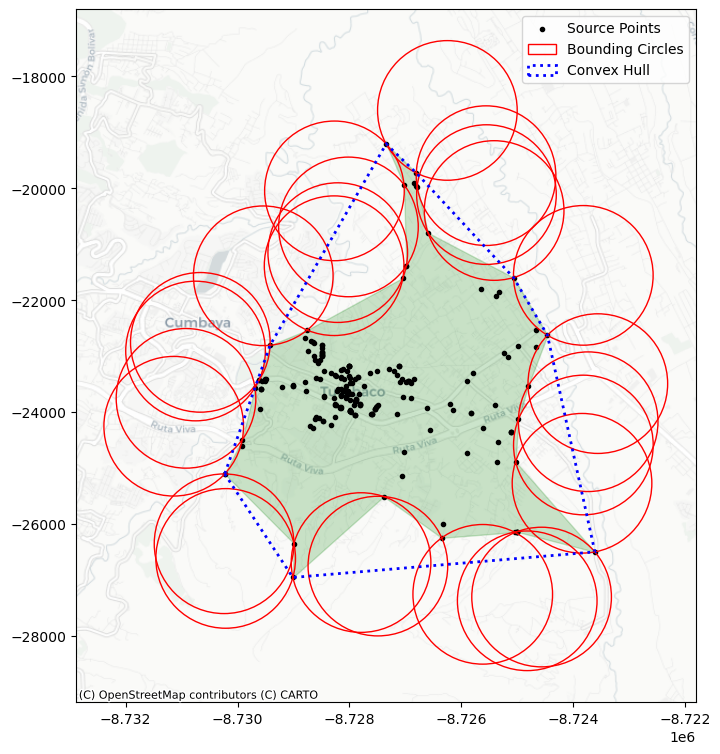

In [37]:
# Se calcula el alpha shape (forma ajustada al borde del conjunto de puntos) automáticamente
# `coordinates`: matriz de coordenadas (x, y)
# `return_circles=True` indica que también se devuelvan los círculos que definen el contorno del alpha shape
alpha_shape, alpha, circs = lps.cg.alpha_shape_auto(
    coordinates, return_circles=True
)

# Se crea una figura y eje para graficar, de tamaño 9x9 pulgadas
f, ax = plt.subplots(1, 1, figsize=(9, 9))

# Se grafica el alpha shape como un polígono verde semitransparente (alpha=0.2)
gpd.GeoSeries(
    [alpha_shape]
).plot(
    ax=ax,
    edgecolor="green",
    facecolor="green",
    alpha=0.2,
    label="Tightest single alpha shape",  # etiqueta para la leyenda
)

# Se grafican los puntos originales en color negro con marcador de punto
ax.scatter(
    *coordinates.T, color="k", marker=".", label="Source Points"
)

# Se grafican los círculos que forman el contorno del alpha shape
for i, circle in enumerate(circs):
    # Solo se etiqueta el primer círculo en la leyenda
    if i == 0:
        label = "Bounding Circles"
    else:
        label = None
    
    # Se agrega el círculo como un parche (no relleno, solo borde rojo)
    ax.add_patch(
        plt.Circle(
            circle,            # centro del círculo
            radius=alpha,      # mismo radio para todos los círculos
            facecolor="none",
            edgecolor="r",
            label=label,
        )
    )

# Se añade el convex hull (envolvente convexa) como un polígono azul punteado
# `convex_hull_vertices` debe contener las coordenadas de los vértices del convex hull
ax.add_patch(
    plt.Polygon(
        convex_hull_vertices,
        closed=True,             # cierra el polígono
        edgecolor="blue",
        facecolor="none",
        linestyle=":",           # línea punteada
        linewidth=2,
        label="Convex Hull",
    )
)

# Se añade un mapa base (contextily) como fondo, con estilo Positron (blanco y limpio)
ctx.add_basemap(
    ax, 
    # crs="EPSG:4326",  # Comentado porque se asume sistema proyectado (EPSG:3857)
    source=ctx.providers.CartoDB.Positron
)

# Se muestra la leyenda con todas las etiquetas agregadas
plt.legend();


## Aleatoriedad y Agrupamiento Espacial

Más allá de la centralidad y la extensión, un objetivo fundamental en el análisis espacial de patrones de puntos es entender **qué tan uniformemente distribuidos** están los eventos en el espacio. En otras palabras, se busca identificar si los puntos tienden a **agruparse** (clustering) o si están **dispersos** de forma homogénea.

**¿Qué se analiza?**

Este tipo de preguntas se refiere a la **intensidad** o **dispersión global** del patrón. En términos de estadística espacial, se relaciona con conceptos como la **autocorrelación espacial global**, que mide si los eventos tienden a ocurrir cerca unos de otros.

**Objetivo**

El propósito es responder preguntas como:

- ¿Hay evidencia de **agrupamientos significativos**?
- ¿Es el patrón compatible con una distribución aleatoria?
- ¿Dónde se concentran más intensamente los eventos?

### Técnicas para detectar agrupamiento

**1. Estadísticos de cuadrantes (Quadrat Statistics)**

- Dividen el área de estudio en **pequeñas celdas regulares** (cuadrantes).
- Se cuenta cuántos puntos caen en cada celda.
- Luego se analiza la **uniformidad** de los conteos entre celdas.
- Son útiles para detectar **variaciones espaciales globales**.

**2. Funciones de distancia: Métodos derivados de Ripley (1988)**

- Se basan en medir las **distancias entre puntos** dentro del patrón.
- Evalúan si los puntos están **más cerca o más lejos entre sí** que lo que se esperaría bajo una distribución aleatoria.
- Métodos como la **función K de Ripley** permiten analizar el **agrupamiento a distintas escalas espaciales**.

**Importancia en análisis urbano**

Estas técnicas son fundamentales para estudiar fenómenos como la delincuencia, donde identificar **zonas calientes**, **concentraciones no aleatorias** o **puntos críticos de intervención** puede guiar acciones de política pública más efectivas.

Los análisis de aleatoriedad y agrupamiento ayudan a distinguir entre una distribución espacial **estructurada** (por ejemplo, vinculada a factores urbanos o sociales) y una distribución **aleatoria**.


In [23]:
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)

**Simulación de Aleatoriedad Espacial: Proceso de Poisson**

Para entender mejor cómo se comporta un patrón de puntos real, es útil compararlo con un patrón generado a partir de un proceso completamente aleatorio. En análisis espacial, este tipo de referencia se conoce como un **proceso de puntos de Poisson**.

**¿Qué es un Proceso de Poisson?**

- Es un modelo que genera **eventos distribuidos aleatoriamente en el espacio**.
- No presenta **agrupamiento ni repulsión** entre puntos.
- Sirve como **patrón de referencia nulo**, contra el cual se puede contrastar la distribución observada.

En otras palabras, bajo un proceso de Poisson:

- La **ubicación** y el **número de puntos** se generan al azar.
- No hay estructura, tendencia, ni dependencia espacial.

**¿Para qué sirve esta comparación?**

- Permite evaluar si un patrón observado **difiere significativamente de lo esperado por azar**.
- Ayuda a identificar si existe evidencia de **agrupamiento espacial**, **dispersión estructurada** o **zonas de concentración**.
- Es fundamental para validar técnicas como la función K de Ripley o el análisis de cuadrantes.

**Simulación en Python**

El paquete `pointpats` proporciona un módulo específico (`pointpats.random`) para simular patrones de Poisson a partir de un conjunto de datos.

- Se puede definir un área de estudio y generar un número aleatorio de puntos dentro de esa región.
- Este patrón simulado sirve como **base de comparación estadística** frente al patrón real.

**Aplicación práctica**

En el análisis de delitos urbanos, por ejemplo, generar un patrón aleatorio con la misma cantidad de eventos permite determinar si los delitos **ocurren al azar** o si existen **zonas donde la concentración es estadísticamente significativa**.

El proceso de Poisson actúa como **modelo nulo espacial** y es una herramienta clave en la detección de agrupamientos reales frente a distribuciones aleatorias.


In [24]:
random_pattern = random.poisson(coordinates, size=len(coordinates))

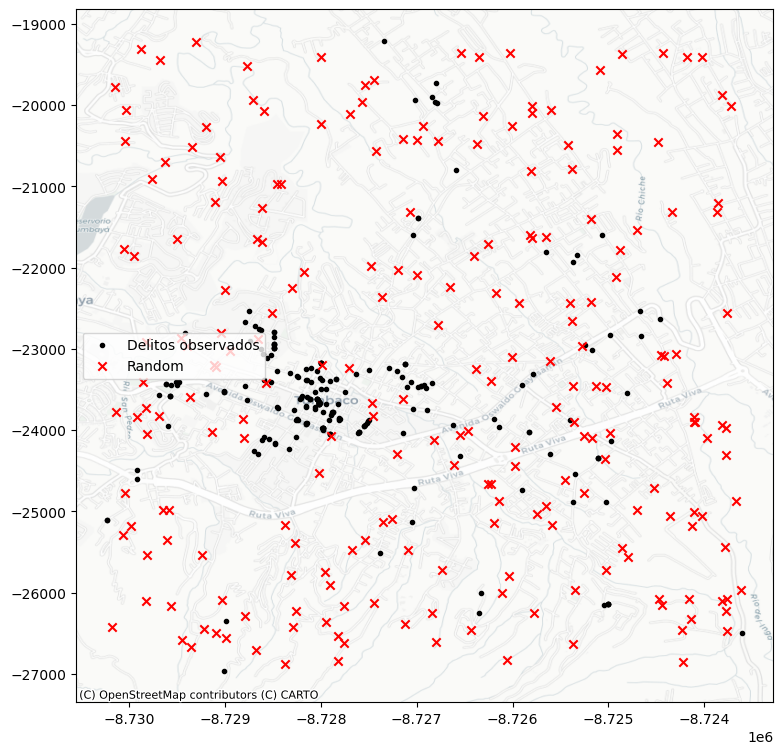

In [36]:
# Se crea una figura y un eje (ax) para graficar, con un tamaño de 9x9 pulgadas
f, ax = plt.subplots(1, figsize=(9, 9))

# Se grafican las coordenadas del patrón observado (por ejemplo, delitos reales)
# Se representan como puntos negros (marker='.') y se etiquetan en la leyenda
plt.scatter(
    *coordinates.T,           # Transpone para separar x e y
    color="k",                # Color negro
    marker=".",               # Marcador tipo punto
    label="Delitos observados"
)

# Se grafican las coordenadas de un patrón aleatorio (simulado bajo hipótesis de aleatoriedad espacial)
# Se representa con cruces rojas (marker='x') para diferenciarlos claramente del patrón real
plt.scatter(
    *random_pattern.T,       # Transpone para separar x e y
    color="r",                # Color rojo
    marker="x",               # Marcador tipo cruz
    label="Random"            # Etiqueta para la leyenda
)

# Se añade un mapa base (estilo CartoDB Positron) para dar contexto geográfico al patrón
# Se asume que las coordenadas están en el sistema proyectado EPSG:3857 (requerido por contextily)
ctx.add_basemap(
    ax,
    # crs="EPSG:4326",  # Comentado porque ya se trabaja en coordenadas proyectadas
    source=ctx.providers.CartoDB.Positron
)

# Se añade una leyenda, con una sola columna, ubicada en el borde izquierdo del centro del gráfico
ax.legend(ncol=1, loc="center left")

# Se muestra el gráfico completo
plt.show()


Como se observa en la simulación básica, el generador de patrones aleatorios —por defecto— utiliza el **rectángulo envolvente (bounding box)** del patrón original como área de referencia. Sin embargo, este enfoque puede ser poco representativo si el patrón observado está concentrado en un espacio **más restringido o con una forma compleja**.

En este caso es mejor generar los puntos aleatorios en el marco de alguna envoltura (`alpha_shape`):


In [26]:
random_pattern_ashape = random.poisson(
    alpha_shape, size=len(coordinates)
)

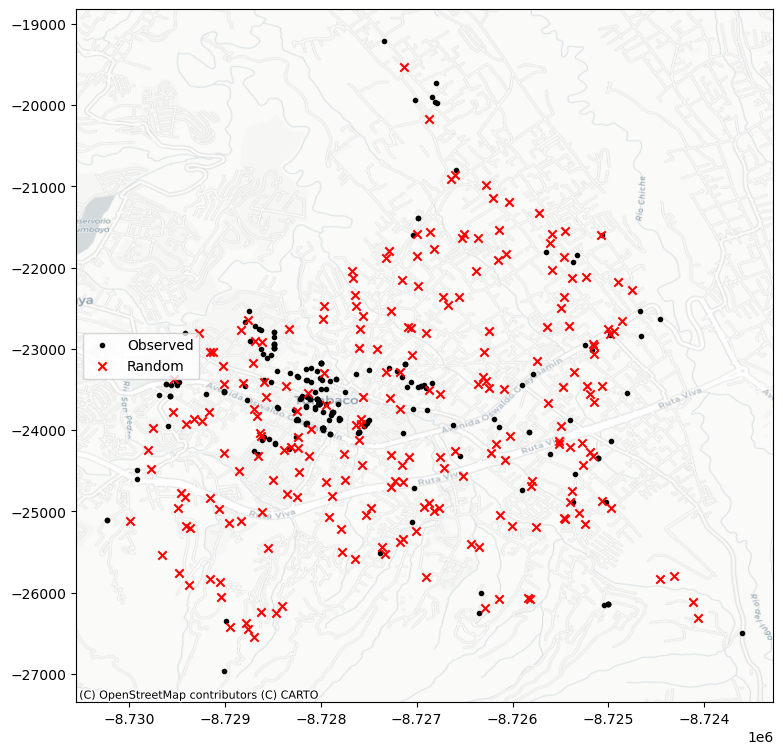

In [35]:
# Se crea una figura y un único eje (ax) con un tamaño de 9x9 pulgadas
f, ax = plt.subplots(1, figsize=(9, 9))

# Se grafican los puntos del patrón observado (por ejemplo, eventos reales como delitos)
# Las coordenadas están separadas en columnas x e y, y se representan como puntos negros ('.')
plt.scatter(*coordinates.T, color="k", marker=".", label="Observed")

# Se grafican los puntos de un patrón aleatorio (generado bajo hipótesis de aleatoriedad espacial completa)
# Se muestran como cruces rojas ('x') para diferenciarlos visualmente
plt.scatter(
    *random_pattern_ashape.T, color="r", marker="x", label="Random"
)

# Se añade un mapa base con estilo claro (CartoDB Positron) usando contextily
# El mapa se proyecta automáticamente (se asume que las coordenadas están en EPSG:3857)
ctx.add_basemap(
    ax, 
    # crs="EPSG:4326",  # Comentado porque los datos ya están proyectados en coordenadas métricas
    source=ctx.providers.CartoDB.Positron
)

# Se añade una leyenda al gráfico con una columna, ubicada al centro a la izquierda del eje
ax.legend(ncol=1, loc="center left")

# Se muestra la figura completa
plt.show()


## Estadísticos de Cuadrantes (Quadrat Statistics)

Los **estadísticos de cuadrantes** son una técnica clásica para analizar la **distribución espacial** de eventos, mediante el conteo de puntos que caen dentro de **celdas regulares** (cuadrantes) que dividen el área de estudio.

**¿Cómo funciona?**

- El área total se divide en una **cuadrícula de celdas iguales**.
- Se cuenta cuántos eventos caen dentro de cada celda.
- Se analiza si los conteos están **uniformemente distribuidos** o si se concentran en unas pocas celdas.

**Objetivo**

La idea principal es detectar si los puntos están:

- **Distribuidos homogéneamente** (como en un proceso aleatorio), o
- **Agrupados en ciertas zonas** (indicando clustering o patrones no aleatorios).

**Fundamento estadístico**

- Este enfoque se basa en una **prueba estadística** similar a la utilizada en el análisis de **tablas de contingencia** (por ejemplo, la prueba de **Chi-cuadrado**).
- Compara la distribución observada de conteos con una distribución esperada bajo el supuesto de aleatoriedad espacial.

**Visualización en Python**

El paquete `pointpats` permite aplicar este análisis y visualizarlo mediante el método `QStatistic.plot()`, que genera una figura (como la Figura 11) mostrando:

- La **cuadrícula utilizada** para el conteo.
- El **patrón de puntos subyacente**.

Esto permite observar visualmente **qué celdas concentran más eventos** y si existe una distribución equitativa.

**Aplicaciones**

En análisis urbanos (como delitos en Quito), este método es útil para:

- Detectar **zonas críticas** donde se acumulan eventos.
- Evaluar si los incidentes están **aleatoriamente distribuidos** o siguen un patrón estructurado.
- Justificar la **intervención focalizada** en ciertos sectores del espacio urbano.

Los cuadrantes ofrecen una forma intuitiva y estadística de explorar **la regularidad o agrupamiento** en patrones espaciales.


<Axes: title={'center': 'Quadrat Count'}>

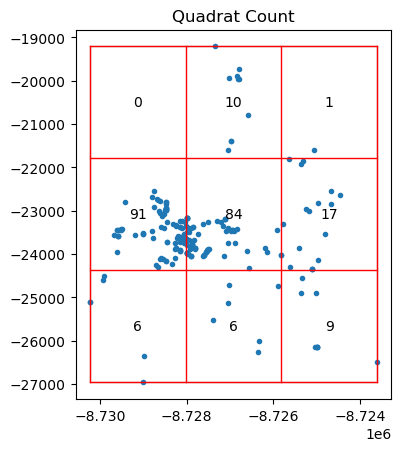

In [30]:
qstat = QStatistic(coordinates)
qstat.plot()

La función `QStatistic(coordinates)` implementa la estadística **Q de dispersión espacial**, propuesta por Rodríguez & Bivand (2007). Esta estadística permite medir el grado de **agrupamiento** o **dispersión** de un conjunto de puntos geográficos, comparándolo con un patrón de distribución completamente aleatoria (CSR: *Complete Spatial Randomness*).

Objetivo

Evaluar si un conjunto de puntos georreferenciados se encuentra:

- Agrupado (clustered)
- Disperso (dispersed)
- Aleatoriamente distribuido (CSR)

Supuestos

Dado un conjunto de puntos:

$$
X = \{ x_1, x_2, \ldots, x_n \}, \quad x_i \in \mathbb{R}^2
$$

Donde cada $ x_i $ representa una coordenada espacial.

**Cálculo de la estadística Q**

**1. Rejilla espacial**

El área de estudio se divide en una rejilla de $ m $ celdas (cuadrantes) de tamaño uniforme.

**2. Conteo de puntos por celda**

Se calcula el número de puntos en cada celda $ j $:

$$
f_j = \text{número de puntos en la celda } j, \quad j = 1, 2, ..., m
$$

**3. Estadística Q**

$$
Q = \frac{1}{n} \sum_{j=1}^{m} f_j^2
$$

Donde:
- $n$ es el total de puntos
- $f_j$ es el número de puntos en la celda $j$

Esta expresión mide la **media cuadrática de los conteos por celda**, lo que penaliza la concentración excesiva en pocas celdas.


**Interpretación del Resultado: Distribución No Uniforme**

En este ejemplo, al aplicar una **cuadrícula de 3x3** sobre el patrón de puntos (como fotografías geolocalizadas en Flickr), observamos que:

- Las **celdas periféricas** tienen muchas menos observaciones.

**¿Qué implica esto?**

Esta distribución indica un **agrupamiento evidente** en el centro del área analizada, lo que **rompe con la suposición de uniformidad** que se esperaría bajo un proceso espacial completamente aleatorio.

### Prueba de chi-cuadrado

La prueba de **Chi-cuadrado** compara los conteos observados en cada celda con los conteos esperados bajo el supuesto de una distribución uniforme. En este caso:

- La gran diferencia entre el conteo de la celda central y las demás genera un **valor del estadístico chi-cuadrado alto**.
- Esto se traduce en un **p-valor muy bajo**, lo que sugiere que la **distribución observada no es aleatoria**.

**Conclusión**

El resultado es **estadísticamente significativo**, lo que implica que hay evidencia suficiente para rechazar la hipótesis nula de uniformidad espacial. En otras palabras, **los puntos están agrupados** en lugar de distribuidos de forma homogénea.

Este tipo de análisis es clave para identificar **zonas calientes** o **puntos críticos** en estudios espaciales, como los relacionados con delitos, servicios urbanos o comportamiento humano en el territorio.


In [31]:
qstat.chi2_pvalue

np.float64(1.8598066523883764e-84)

<Axes: title={'center': 'Quadrat Count'}>

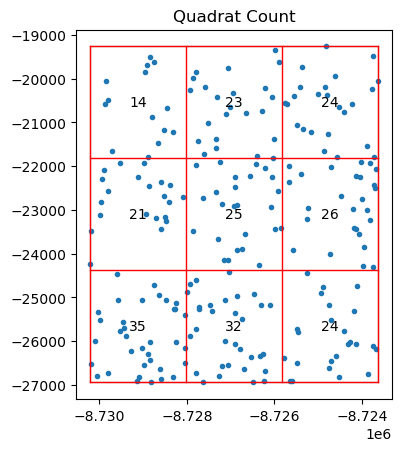

In [33]:
qstat_null = QStatistic(random_pattern)
qstat_null.plot()



En contraste con el patrón observado (agrupado), cuando generamos un patrón a partir de un **proceso de puntos completamente aleatorio** (como el **proceso de Poisson**), la distribución de eventos en la cuadrícula es **mucho más uniforme**.


Tiene un pvalor alto y no significativo

In [34]:
qstat_null.chi2_pvalue

np.float64(0.16186593811090463)



Si bien los **estadísticos de cuadrantes** son una herramienta poderosa para detectar agrupamiento espacial, es importante tener en cuenta sus **limitaciones** y el contexto de aplicación.

**Problema: Superposición regular sobre un patrón irregular**

El método se basa en superponer una **cuadrícula regular** (rejilla) sobre el área de estudio, pero:

- Si el **patrón de puntos tiene una forma irregular** (como un **alpha shape**),
- Y la cuadrícula no se ajusta a esa forma (es decir, incluye áreas vacías o exteriores),

Entonces, los resultados pueden ser **engañosos**.

**Posible consecuencia**

- Un **patrón aleatorio e irregular** (simulado dentro de un alpha shape) puede ser clasificado erróneamente como **agrupado** si las celdas caen en áreas sin puntos simplemente por la forma del polígono.
- Esto puede generar un **estadístico chi-cuadrado elevado** y un **p-valor bajo**, sugiriendo falsamente agrupamiento.

**Ejemplo en la Figura**

En la **Figura**, se observa un patrón aleatorio generado dentro de un **alpha shape**. Al aplicar una cuadrícula regular por fuera, algunas celdas incluyen **zonas sin puntos** simplemente porque caen fuera del área válida, distorsionando así los conteos y el análisis.

### Recomendación

Para evitar interpretaciones erróneas:

- Asegúrate de que la cuadrícula se **ajuste adecuadamente al área real del patrón**.
- Considera usar métodos alternativos o complementarios (como **Ripley’s K**, KDE, o alpha shapes) para validar los resultados.
- Siempre **verifica visualmente** el ajuste entre la cuadrícula y el área de estudio.

El análisis por cuadrantes es útil, pero debe aplicarse con cuidado cuando se trabaja con **patrones espaciales de extensión irregular**.


<Axes: title={'center': 'Quadrat Count'}>

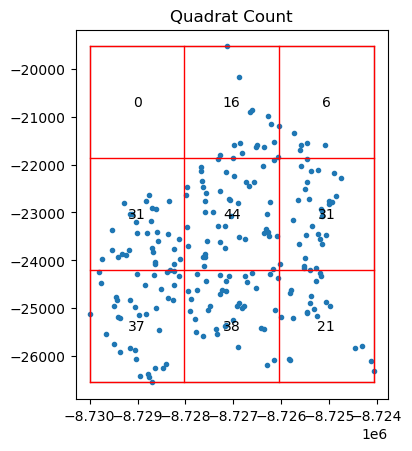

In [28]:
qstat_null_ashape = QStatistic(random_pattern_ashape)
qstat_null_ashape.plot()

La prueba de cuadrantes determina que esto no es aleatorio desde el punto de vista estadístico, mientras que nuestro proceso de simulación garantizó que, dentro del área de estudio definida, el patrón corresponde a un proceso completamente aleatorio en el espacio.

In [29]:
qstat_null_ashape.chi2_pvalue

np.float64(9.926055574192699e-13)

**Limitaciones de los Estadísticos de Cuadrantes**

Los **estadísticos de cuadrantes** pueden ser problemáticos cuando se aplican a áreas de estudio **irregulares**, ya que podrían **identificar falsamente agrupamiento**.

Una forma más adecuada de interpretarlos es considerarlos como una prueba que evalúa tanto la **uniformidad de los puntos** como la **forma del área analizada**, dentro de una **rejilla regular**.

**Conclusión**

- En algunos casos, esta técnica es **útil y válida**.
- En otros, debe aplicarse **con precaución** para evitar conclusiones erróneas sobre la existencia de agrupamiento.


### Funciones de Ripley

El segundo conjunto de estadísticas espaciales se enfoca en analizar dos aspectos clave en los patrones de puntos:

1. Las **distancias al vecino más cercano**, y  
2. Los **“vacíos”** o huecos dentro del patrón.

Estas técnicas derivan del trabajo seminal de [**Ripley (1991)**](https://www.wiley.com/en-us/Spatial+Statistics-p-9780471725206), cuyo objetivo fue **caracterizar el grado de agrupamiento o co-ubicación** en patrones espaciales, evaluando cómo cambian estas relaciones al **aumentar progresivamente la distancia de análisis** desde cada punto.

#### Función G de Ripley: Vecinos más cercanos

La primera función de este conjunto es la **función G**, que resume la distribución de las **distancias al vecino más cercano** para cada punto del patrón.

- Para cada punto, se calcula la distancia al **punto más próximo**.
- Luego, se construye una función acumulativa que indica la **proporción de puntos que tienen un vecino a una distancia menor o igual a un valor dado**.

### Interpretación

- Si el patrón es **agrupado**, muchos puntos tendrán vecinos muy cercanos → la función G crecerá rápidamente.
- Si es **disperso o uniforme**, las distancias serán mayores → la función crecerá más lentamente.
- Comparar la función G observada con la esperada bajo un **patrón aleatorio** (como un proceso de Poisson) permite detectar **agrupamiento o repulsión**.

Estas herramientas permiten un análisis más detallado de la **estructura interna** del patrón, más allá de la simple ubicación o conteo de eventos.


Para hacer esto con el paquete `pointpats`, podemos usar la función `g_test`, la cual calcula tanto la función G para los datos empíricos como las réplicas hipotéticas bajo un proceso completamente aleatorio en el espacio.


- La **función G(r)** es una función de distribución acumulada empírica que describe la **distribución de las distancias al vecino más cercano** en un patrón de puntos espacial.

- Mide el grado de **agrupamiento a pequeña escala**, observando **qué tan cerca** están los puntos entre sí.

**Interpretación intuitiva**

Para un conjunto de puntos en el plano, la función \( G(r) \) nos dice:

> ¿Cuál es la **proporción de puntos** cuyo **vecino más cercano** se encuentra a una distancia **menor o igual que \( r \)**?


**Cálculo**

Dado un conjunto de $ n $ puntos $ \{x_1, x_2, \ldots, x_n\} $ en $ \mathbb{R}^2 $:

**1. Calcular distancias al vecino más cercano**

Para cada punto $ x_i $, se calcula la distancia a su punto más cercano (excluyéndose a sí mismo):

$$
d_i = \min_{j \ne i} \, d(x_i, x_j)
$$

Donde $ d(x_i, x_j) $ es la distancia euclidiana entre los puntos $ x_i $ y $ x_j $.

**2. Construir función acumulativa empírica**

Luego, se define la función:

$$
G(r) = \frac{1}{n} \sum_{i=1}^{n} \mathbb{1}_{\{d_i \leq r\}}
$$

Donde:

- $ \mathbb{1}_{\{d_i \leq r\}} $ es una **función indicadora** que vale 1 si $ d_i \leq r $ y 0 en caso contrario.
- $ G(r) $ es entonces la **proporción de puntos** cuyo vecino más cercano está dentro de una distancia $ r $.


**Comparación con CSR (Complete Spatial Randomness)**

Para detectar agrupamiento o dispersión, se compara $ G(r) $ con su valor esperado bajo **Complete Spatial Randomness (CSR)**.

- Si el patrón observado **crece más rápido** que CSR: hay **agrupamiento**.
- Si crece **más lento**: hay **dispersión o inhibición** (como en árboles plantados uniformemente).

La forma esperada bajo CSR (para puntos aleatorios en un área $ A $ de densidad $ \lambda $) es:

$$
G_{\text{CSR}}(r) = 1 - e^{-\lambda \pi r^2}
$$

Esto surge porque bajo CSR, los puntos se distribuyen como un **proceso de Poisson** y la probabilidad de que no haya otro punto en un círculo de radio $ r $ es $ e^{-\lambda \pi r^2} $.

Consideraciones:

- La función G es **sensible al borde**: puntos cerca del límite del área de estudio pueden tener vecinos "ocultos" fuera del área. Por eso, se aplican **correcciones de borde**.
- Es una función **univariada**, centrada en **distancias entre puntos**, sin considerar atributos asociados.

La función G permite describir la **estructura local** del patrón de puntos. Su interpretación como una función de distribución acumulada la hace especialmente útil para **visualizar y comparar patrones observados con simulaciones aleatorias (CSR)**.



In [30]:

g_test = distance_statistics.g_test(
    coordinates, support=40, keep_simulations=True
)



Cuando analizamos la distribución de **distancias al vecino más cercano**, podemos clasificar el patrón de puntos de la siguiente manera:

- Un patrón **agrupado (clustered)** tendrá **más puntos cercanos entre sí** → la función **G** crecerá **rápidamente**.
- Un patrón **disperso** tendrá puntos **más alejados** → la función G crecerá **lentamente**.
- Un patrón **aleatorio** tendrá un crecimiento **intermedio**, sin tendencia clara.

**Gráficamente**

En la **Figura**, se muestra cómo se interpreta gráficamente esta función:

- El eje horizontal representa la **distancia al punto más cercano** (d).
- El eje vertical representa la **proporción acumulada** de puntos que tienen un vecino a una distancia ≤ d.
- La **línea roja** muestra la **función G empírica** calculada a partir de los datos observados (por ejemplo, fotos de un usuario de Flickr).
- Las **líneas azules** representan múltiples simulaciones bajo un **patrón completamente aleatorio** (Poisson):
  - La línea azul clara es el **promedio** de esas simulaciones.
  - La banda azul oscura/negra indica el **intervalo de confianza del 95%** de los resultados simulados.

**Conclusión del ejemplo**

En este caso, la **línea roja asciende más rápidamente** que las simulaciones aleatorias, lo que indica que:

- Los puntos observados (fotografías) están **más cerca entre sí** de lo que cabría esperar por azar.
- Por lo tanto, el patrón es **agrupado**, mostrando **evidencia clara de clustering**.

Este análisis es útil para confirmar, con base estadística, que un patrón espacial tiene **estructura interna no aleatoria**, lo que puede tener implicaciones importantes para estudios de comportamiento humano, movilidad, o fenómenos urbanos como el crimen.


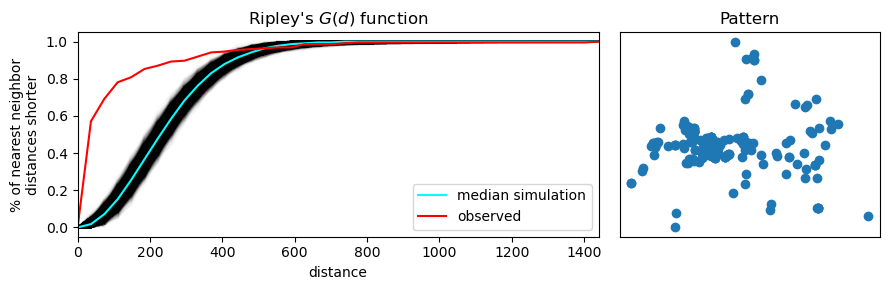

In [32]:
# Se crea una figura con dos subgráficos (subplots) en una fila (1) y dos columnas (2)
# figsize define el tamaño total de la figura: 9 pulgadas de ancho y 3 de alto
# gridspec_kw especifica que el primer gráfico será el doble de ancho que el segundo (proporción 6:3)
f, ax = plt.subplots(
    1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3))
)

# En el primer subplot (ax[0]), se grafican todas las simulaciones de la función G (G simulada)
# Cada simulación se grafica con líneas negras muy finas (alpha=0.01) para crear una "nube"
ax[0].plot(
    g_test.support, g_test.simulations.T, color="k", alpha=0.01
)

# Se grafica la **mediana** de las simulaciones con una línea cian
# Esto representa el comportamiento esperado bajo un patrón completamente aleatorio
ax[0].plot(
    g_test.support,
    np.median(g_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)

# Se añade la curva observada de la función G (patrón empírico) con línea roja
ax[0].plot(
    g_test.support, g_test.statistic, label="observed", color="red"
)

# Se agregan etiquetas y leyenda al primer subplot
ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest neighbor\ndistances shorter")  # texto dividido en dos líneas
ax[0].legend()
ax[0].set_xlim(0, np.max(g_test.support))  # se ajusta el límite del eje X
ax[0].set_title(r"Ripley's $G(d)$ function")  # título con notación matemática LaTeX

# En el segundo subplot (ax[1]), se grafica el patrón espacial real (coordenadas de los puntos)
ax[1].scatter(*coordinates.T)

# Se eliminan etiquetas y ticks para que el gráfico se vea más limpio
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")

# Se ajusta automáticamente el diseño para que no se superpongan los elementos
f.tight_layout()

# Se muestra la figura completa con ambos gráficos
plt.show()


La segunda función que introducimos es la **función F de Ripley**, también conocida como la **función del espacio vacío**. A diferencia de la función G, que mide las distancias **entre puntos del patrón**, la función F analiza la distancia **desde ubicaciones aleatorias en el espacio hacia el punto más cercano del patrón**.

**¿Qué mide la función F?**

- Evalúa la **proximidad de puntos del patrón a ubicaciones aleatorias en el espacio**.
- A medida que se incrementa la distancia \( d \), la función acumula el **porcentaje de esos puntos aleatorios** que caen a una distancia menor o igual a \( d \) de algún punto del patrón observado.
- Por eso se le llama la **función del espacio vacío**: mide cuánto “vacío” hay en el patrón.

**Interpretación**

Para una distancia $r$, la función $F(r)$ responde:

> ¿Cuál es la **proporción de ubicaciones aleatorias** del área de estudio cuya **distancia al punto más cercano del patrón** es **menor o igual que $r$**?

- Si el patrón tiene **grandes vacíos o huecos**, la función F crecerá **lentamente** → indica **agrupamiento**.
- Si el patrón está **muy disperso**, la función F crecerá **rápidamente**, ya que es más probable que cualquier punto aleatorio esté cerca de un evento.

**Cálculo**

**1. Seleccionar ubicaciones aleatorias**

Se eligen $ m $ ubicaciones al azar dentro del área de estudio:

$$
\{ s_1, s_2, \ldots, s_m \}, \quad s_i \in \text{Área}
$$

**2. Calcular distancia al punto más cercano**

Para cada punto aleatorio $ s_i $, se calcula la distancia al punto más cercano del patrón observado:

$$
d_i = \min_{j} \, d(s_i, x_j)
$$

Donde $ x_j $ son los puntos del patrón.

**3. Construir la función acumulativa**

$$
F(r) = \frac{1}{m} \sum_{i=1}^{m} \mathbb{1}_{\{d_i \leq r\}}
$$

- $ \mathbb{1}_{\{d_i \leq r\}} $ es la función indicadora (1 si $ d_i \leq r $, 0 en otro caso).
- $ F(r) $ es la proporción de ubicaciones aleatorias que están dentro de una distancia $ r $ de algún punto del patrón.


**Gráficamente**

Al igual que con la función G, se compara la función F del patrón observado con:

- Una **media** de múltiples simulaciones aleatorias (línea azul clara).
- Un **intervalo de confianza del 95%** basado en simulaciones (banda azul oscuro o negra).

Si la **función F empírica (roja)** crece **más lentamente** que la banda de simulaciones aleatorias, esto indica que:

- En el patrón hay **mayor cantidad de espacio vacío** del que esperaríamos por azar.
- El patrón es, por tanto, **agrupado (clustered)**.




**Comparación con CSR**

Bajo un modelo de **Complete Spatial Randomness (CSR)**, se espera que $ F(r) $ siga la forma teórica:

$$
F_{\text{CSR}}(r) = 1 - e^{-\lambda \pi r^2}
$$

Donde:
- $ \lambda $ es la densidad del patrón (número de puntos por unidad de área).
- Igual que la función $ G(r) $ teórica bajo CSR.


## Diferencias  con la función G

| Característica | Función G | Función F |
|----------------|-----------|-----------|
| Desde dónde se miden las distancias | Desde los puntos del patrón | Desde puntos aleatorios del espacio |
| Qué se mide | Vecino más cercano | Punto más cercano del patrón |
| Enfoque | Relación entre puntos | Relación del patrón con el espacio vacío |


La función F es útil para analizar **cómo los puntos llenan el espacio**. Combinada con la función G, permite caracterizar de forma más completa el patrón espacial observado, detectando **agujeros**, **aglomeraciones** y **distribuciones no aleatorias**.



**Cálculo en Python**

La función F se implementa en `pointpats` mediante la función `f_test()`, y su análisis gráfico es análogo al de la función G.

**Conclusión**

La función F ofrece una perspectiva complementaria sobre la **estructura espacial** del patrón, ayudando a detectar **áreas sin eventos** (gaps) y a confirmar la **presencia de agrupamiento** cuando los puntos están concentrados en ciertas regiones del espacio.


In [33]:

f_test = distance_statistics.f_test(
    coordinates, support=40, keep_simulations=True
)

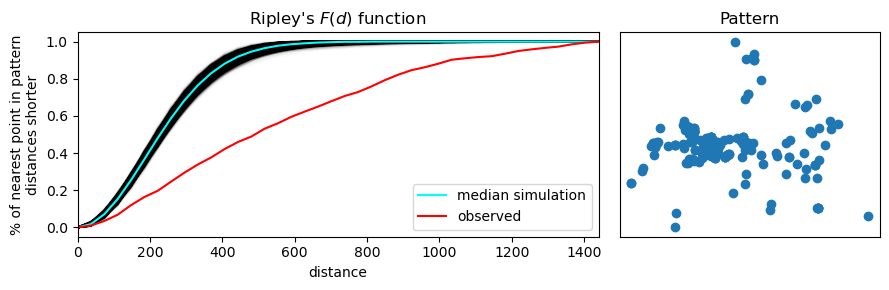

In [34]:
# Se crea una figura con dos subgráficos (subplots): uno para la función F y otro para el patrón espacial.
# La figura tiene tamaño 9x3 pulgadas. El primer subplot (izquierda) será el doble de ancho que el segundo (derecha).
f, ax = plt.subplots(
    1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3))
)

# Se grafican todas las simulaciones de la función F (distancias desde puntos aleatorios a los más cercanos del patrón)
# Cada línea negra representa una simulación, y se usa transparencia alta (alpha=0.01) para crear una nube visual.
ax[0].plot(
    f_test.support, f_test.simulations.T, color="k", alpha=0.01
)

# Se grafica la **mediana** de las simulaciones en color cian.
# Esto representa el comportamiento esperado bajo un patrón completamente aleatorio.
ax[0].plot(
    f_test.support,
    np.median(f_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)

# Se grafica la función F **observada** (derivada del patrón real de puntos) en color rojo.
ax[0].plot(
    f_test.support, f_test.statistic, label="observed", color="red"
)

# Etiquetas del gráfico de la izquierda (función F)
ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest point in pattern\ndistances shorter")  # dividido en dos líneas
ax[0].legend()  # se añade la leyenda con etiquetas de líneas
ax[0].set_xlim(0, np.max(f_test.support))  # define los límites del eje x
ax[0].set_title(r"Ripley's $F(d)$ function")  # título con formato LaTeX

# En el subplot derecho (ax[1]) se grafica el patrón espacial observado
ax[1].scatter(*coordinates.T)

# Se eliminan etiquetas y marcas del eje para un gráfico limpio
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")  # título del patrón

# Se ajusta automáticamente el diseño para evitar superposición de los elementos
f.tight_layout()

# Se muestra la figura completa
plt.show()
